# WORD2VEC

### 신경망에서의 단어 처리

In [1]:
import numpy as np

c = np.array([[1,0,0,0,0,0,0]]) # 2dim!
W = np.random.randn(7,3)
h = np.matmul(c, W)
print(h)

[[-1.42703918 -0.23071713 -0.35869061]]


In [3]:
print(W[:1,:]) #가중치의 첫 행을 빼온것!

[[-1.42703918 -0.23071713 -0.35869061]]


In [8]:
import sys
sys.path.append("../book/")

from common.layers import MatMul

layer = MatMul(W)
h = layer.forward(c) 
print(h)
print(layer.backward(np.random.randn(1,3)))

[[-1.42703918 -0.23071713 -0.35869061]]
[[ 1.31551648  0.26386917 -1.66011383  2.51624385  2.24990402  3.10349407
   0.1911882 ]]


## 단순한 word2vec

In [10]:
# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in) # 중첩!
in_layer1 = MatMul(W_in) # 중첩!
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1) #평균!
s = out_layer.forward(h)
print(s)

[[-0.32153031  0.73061716 -0.03976225  1.06962552  1.49339356  1.09924355
  -0.90143653]]


### CBOW 모델의 학습

##### 데이터 준비

In [11]:
from common.util import preprocess

text = 'You say goodbye and I say hello.'

corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(word_to_id)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}


In [14]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size] #앞, 뒤 제거
    contexts = []
    
    for idx in range(window_size, len(corpus) - window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if(t == 0):
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [15]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [16]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환

    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [17]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)
print(contexts)
print(target)

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


In [18]:
print(contexts.shape)
print(target.shape)

(6, 2, 7)
(6, 7)


##### CBOW 모델 구현

In [19]:
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f') #표준편차 0.01!
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer] #layer 표현 쉽개!
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in  ##이걸로 분산표현 이용!!

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5 ##평균화!
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da) #backward호출하면 저장됨!
        self.in_layer0.backward(da)
        return None

### Train Model

In [21]:
from common.trainer import Trainer
from common.optimizer import Adam

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam() ##make optimizer like this
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)


| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 963 |  반복 1 / 2 | 시간 0[s] | 손실 0.50
| 에폭 964 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 965 |  반복 1 / 2 | 시간 0[s] | 손실 0.55
| 에폭 966 |  반복 1 / 2 | 시간 0[s] | 손실 0.42
| 에폭 967 |  반복 1 / 2 | 시간 0[s] | 손실 0.54
| 에폭 968 |  반복 1 / 2 | 시간 0[s] | 손실 0.46
| 에폭 969 |  반복 1 / 2 | 시간 0[s] | 손실 0.44
| 에폭 970 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 971 |  반복 1 / 2 | 시간 0[s] | 손실 0.49
| 에폭 972 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 973 |  반복 1 / 2 | 시간 0[s] | 손실 0.39
| 에폭 974 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 975 |  반복 1 / 2 | 시간 0[s] | 손실 0.48
| 에폭 976 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 977 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 978 |  반복 1 / 2 | 시간 0[s] | 손실 0.31
| 에폭 979 |  반복 1 / 2 | 시간 0[s] | 손실 0.72
| 에폭 980 |  반복 1 / 2 | 시간 0[s] | 손실 0.48
| 에폭 981 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 982 |  반복 1 / 2 | 시간 0[s] | 손실 0.50
| 에폭 983 |  반복 1 / 2 | 시간 0[s] | 손실 0.55
| 에폭 984 |  반복 1 / 2 | 시간 0[s] | 손실 0.38
| 에폭 985 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 986 |  반복 1 / 2 | 시간 0[s] | 손실 0.44
| 에폭 987 |  반복 1

/home/dongho/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dongho/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dongho/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dongho/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


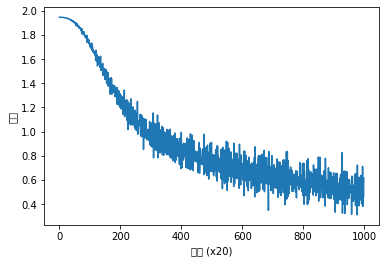

you [-1.0612234  1.1071477  1.1024334  1.5648612  0.5365164]
say [ 1.1189827  -0.40690452 -1.1754854   1.3247083  -1.1402006 ]
goodbye [-0.85744154  0.6458013   0.81541336  0.2857483   1.2888519 ]
and [ 0.66547406 -1.8863498  -0.75899935  1.3662221  -0.71522284]
i [-0.87057525  0.6573278   0.80781394  0.30415922  1.2967623 ]
hello [-1.0535452   1.1038688   1.0874778   1.5604496   0.54530066]
. [ 1.2141771   1.7902037  -1.1799726   0.63889253 -1.1743307 ]


In [23]:
trainer.plot()

word_vecs = model.word_vecs #이렇게 은닉표현 꺼냄!
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

## Skip-Gram 모델

In [24]:
class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None
